In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [2]:
# Load pre-processed data
CL_CRC_BA = pd.read_csv("SingaporeCRC_data/CL_BA.csv", index_col=0, delimiter=",")
CL_CRC_BA = CL_CRC_BA.T
CL_CRC_BA.index.name = 'patient_id'
CL_CRC_BA

,g__Roseburia,g__Enterocloster,g__Blautia,g__Agathobacter,g__Lachnoclostridium,g__Coprococcus,g__Butyrivibrio,g__Lachnospira,g__Anaerostipes,g__Lacrimispora,...,g__Pseudoprevotella,g__Hoylesella,g__Aeromonas,g__Haemophilus,g__Leptotrichia,g__Treponema,g__Megamonas,g__Nocardioides,g__Petrimonas,g__Hymenobacter
patient_id,,,,,,,,,,,,,,,,,,,,,
X47,1.630613,0.183694,1.048691,-0.103988,-0.286310,0.743310,-0.509453,-1.202600,-1.202600,-1.895748,...,1.048691,-0.797135,0.301477,-1.202600,4.982579,0.050162,-1.202600,0.502148,-1.895748,-0.509453
X95,3.889290,3.756106,3.392034,2.982850,0.467386,0.082975,-1.031386,2.413297,1.457481,0.143599,...,1.957178,-4.075908,-4.075908,-4.075908,-4.075908,-3.382761,2.993115,-2.977296,0.488440,0.568483
X106,0.278136,2.215077,0.550070,-1.801306,0.395919,0.550070,-1.801306,-1.395841,-1.108158,-1.801306,...,2.100667,1.289737,-1.801306,-2.494453,-1.801306,-1.801306,-2.494453,-2.494453,-0.191868,-1.801306
X153,0.969917,2.822977,2.356212,1.627973,-2.397378,1.851117,-2.397378,0.000517,0.821497,-1.704231,...,3.136011,3.107953,-1.011084,-2.397378,2.593054,-2.397378,-1.298766,-2.397378,0.860718,-1.704231
X326,0.568649,5.213040,4.422658,-1.829246,0.310820,2.131567,0.310820,-0.730634,1.466591,-2.522393,...,-1.136099,-0.325168,-0.730634,4.895788,0.185657,-2.522393,6.470537,-2.522393,-2.522393,-0.124498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1662,5.667685,1.754647,3.414031,4.914790,0.045475,2.763234,-0.410001,-0.490044,0.797811,-2.751807,...,1.980877,0.045475,-1.029040,-2.058660,1.094076,-3.668097,4.726589,-4.361245,-3.668097,-3.262632
X1664,1.979841,1.979841,0.986589,0.629915,0.293442,1.775047,-1.315996,-1.315996,-0.217383,0.070299,...,-1.315996,-1.315996,-1.315996,0.986589,-1.315996,-1.315996,0.293442,-0.622848,-1.315996,-0.622848
X1665,2.264600,1.971931,4.036258,4.899384,0.893121,1.971931,0.257132,0.257132,1.525643,-1.246945,...,-0.841480,-1.940092,-1.940092,5.129782,-1.246945,-1.246945,-1.246945,-1.940092,-1.940092,-1.940092


In [3]:
metadata = pd.read_csv("SingaporeCRC_data/filtered_metadata.csv", index_col=0,delimiter=",")
metadata = metadata.dropna()
metadata

,patient_id,TMB,KRAS,BRAF,NRAS,TP53,APC,PIK3CA,PIK3R1,SMAD4,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
3,X106,1028,wt,wt,wt,wt,wt,wt,wt,wt,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,IIIC,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X153,80,mut,wt,wt,mut,mut,mut,wt,wt,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,IIIB,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
5,X326,1512,mut,wt,wt,wt,wt,wt,wt,wt,...,55.0,Rectosigmoid junction,Left,2,Unknown,II,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
7,X420,1976,mut,wt,wt,mut,mut,wt,wt,wt,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
8,X470,739,wt,wt,wt,wt,wt,wt,mut,mut,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,IIIB,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,X1658,82,mut,wt,wt,mut,mut,wt,wt,wt,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,IV,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
143,X1662,74,mut,wt,wt,mut,wt,wt,wt,wt,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,IIIB,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
144,X1664,46,mut,wt,wt,mut,wt,wt,wt,wt,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,IIIC,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
145,X1665,93,mut,wt,wt,mut,mut,wt,wt,wt,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,IIIB,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [4]:
SG_CL_CRC_BA = pd.merge(CL_CRC_BA, metadata, on='patient_id', how='inner')
stage_mapping = {
    'I': 'Early Stage',
    'II': 'Early Stage',
    'III': 'Late Stage',
    'IV': 'Late Stage',
    'IIA': 'Early Stage',
    'IIA': 'Early Stage',
    'IIIB': 'Late Stage',
    'IIIC': 'Late Stage',
    'IIC': 'Early Stage',
    'IIB': 'Early Stage',
    'IIIA': 'Late Stage',
    'IVB': 'Late Stage',
    'IVA': 'Late Stage'
}

SG_CL_CRC_BA['Stage'] = SG_CL_CRC_BA['Stage'].replace(stage_mapping)
SG_CL_CRC_BA
#SG_CL_CRC_BA.to_csv('SingaporeCRC_data/SG_CL_CRC_BA', index=False)

,patient_id,g__Roseburia,g__Enterocloster,g__Blautia,g__Agathobacter,g__Lachnoclostridium,g__Coprococcus,g__Butyrivibrio,g__Lachnospira,g__Anaerostipes,...,Age.at.Diagnosis,Site.of.Primary.Colorectal.tumour,Side,Grade,TNM,Stage,iCMS,CMS,group3,group5
0,X106,0.278136,2.215077,0.550070,-1.801306,0.395919,0.550070,-1.801306,-1.395841,-1.108158,...,72.0,Transverse colon,Right,3,T4aN2(4/29)M0,Late Stage,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
1,X153,0.969917,2.822977,2.356212,1.627973,-2.397378,1.851117,-2.397378,0.000517,0.821497,...,66.0,Sigmoid colon,Left,2,T3N1(1/18)M0,Late Stage,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
2,X326,0.568649,5.213040,4.422658,-1.829246,0.310820,2.131567,0.310820,-0.730634,1.466591,...,55.0,Rectosigmoid junction,Left,2,Unknown,Early Stage,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
3,X420,2.876205,0.909352,3.305562,3.162591,-0.135193,1.917580,-1.981020,-0.681737,1.154474,...,58.0,Sigmoid colon,Left,2,T3N1(1/23)M0,Late Stage,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
4,X470,2.681349,4.150283,4.035412,-0.221847,0.893461,2.954944,-0.063376,2.027849,2.042648,...,53.0,Ascending colon,Right,2,T3N1(1/11)M0,Late Stage,iCMS3,CMS1,iCMS3_MSI,iCMS3_MSI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,X1658,3.007520,1.706383,3.311731,1.503442,-0.393678,1.746388,-0.393678,-0.105996,0.859085,...,59.0,Rectum,Left,2,T3N2b(8/22)M1,Late Stage,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS
107,X1662,5.667685,1.754647,3.414031,4.914790,0.045475,2.763234,-0.410001,-0.490044,0.797811,...,67.0,Rectum,Left,2,T3N1a(1/36)M0,Late Stage,iCMS3,CMS3,iCMS3_MSS,iCMS3_MSS
108,X1664,1.979841,1.979841,0.986589,0.629915,0.293442,1.775047,-1.315996,-1.315996,-0.217383,...,62.0,Sigmoid colon,Left,2,T3N2a(6/29)M0,Late Stage,iCMS2,CMS4,iCMS2_MSS,iCMS2_fibrotic
109,X1665,2.264600,1.971931,4.036258,4.899384,0.893121,1.971931,0.257132,0.257132,1.525643,...,78.0,Sigmoid colon,Left,2,T3N1c(0/15)M0,Late Stage,iCMS2,CMS2,iCMS2_MSS,iCMS2_MSS


In [5]:
class_counts = SG_CL_CRC_BA['Stage'].value_counts()
print(class_counts)

Stage
Late Stage     67
Early Stage    44
Name: count, dtype: int64


In [6]:
# Prepare features and target variable
X = SG_CL_CRC_BA.drop(['patient_id', 'TMB', 'KRAS', 'BRAF', 'NRAS', 'TP53', 'APC', 'PIK3CA',
       'PIK3R1', 'SMAD4', 'ERBB4', 'RNF43', 'ZNRF3', 'KIT', 'TGFBR2',
       'Vital.status', 'MSI.Status', 'CRIS', 'Gender', 'Age.at.Diagnosis',
       'Site.of.Primary.Colorectal.tumour', 'Side', 'Grade', 'TNM', 'Stage',
       'iCMS', 'CMS', 'group3', 'group5'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
y = SG_CL_CRC_BA['Stage']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
print("Shape of y:", X_scaled.shape)
print("Shape of y:", y.shape)

Unique values of y: ['Early Stage' 'Late Stage']
Unique values of y: [0 1]
Shape of y: (111, 149)
Shape of y: (111,)


In [7]:
# Oversampling to ensure class balance
from imblearn.over_sampling import SMOTE
#oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
#X_scaled, y = oversampler.fit_resample(X_scaled,y)

sm = SMOTE(sampling_strategy='not majority', k_neighbors= 5, random_state=42)
X_scaled, y = sm.fit_resample(X_scaled, y)

print(X_scaled.shape)
print(y.shape)

(134, 149)
(134,)


Best Parameters: {'alpha': 1, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7004329004329004
Test Set Accuracy: 0.6296296296296297


<Figure size 800x600 with 0 Axes>

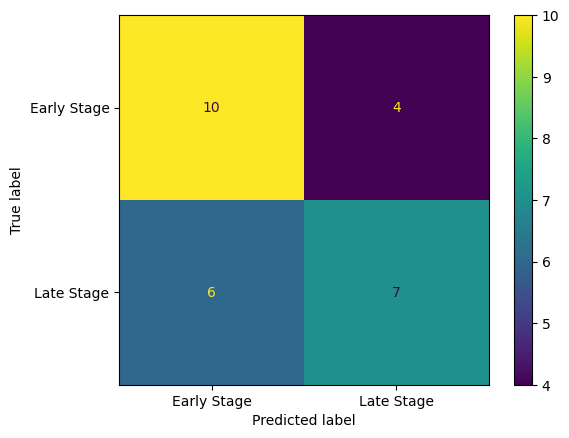

              precision    recall  f1-score   support

 Early Stage       0.62      0.71      0.67        14
  Late Stage       0.64      0.54      0.58        13

    accuracy                           0.63        27
   macro avg       0.63      0.63      0.62        27
weighted avg       0.63      0.63      0.63        27



In [104]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1], # Include L1 regularization
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Early Stage', 'Late Stage'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.show()

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred, target_names=['Early Stage', 'Late Stage'])
print(report)

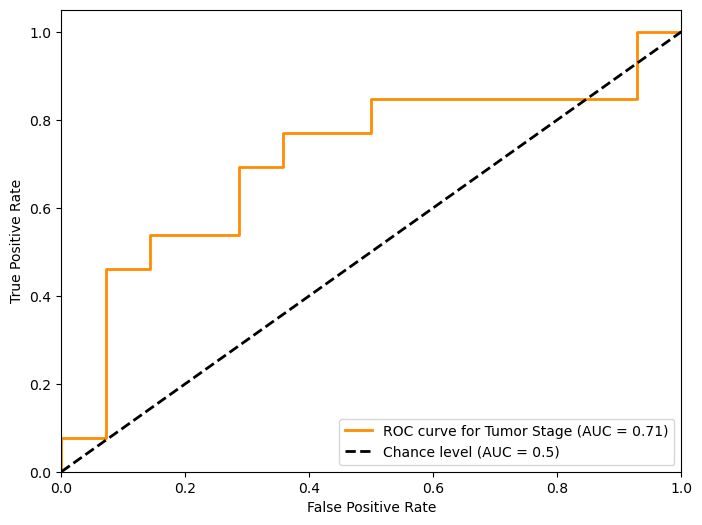

In [105]:
# Predict probabilities
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve for Tumor Stage (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, label=f'Chance level (AUC = 0.5)', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

C:\Users\Zhongyuan\AppData\Local\Temp\ipykernel_27964\2900214027.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")


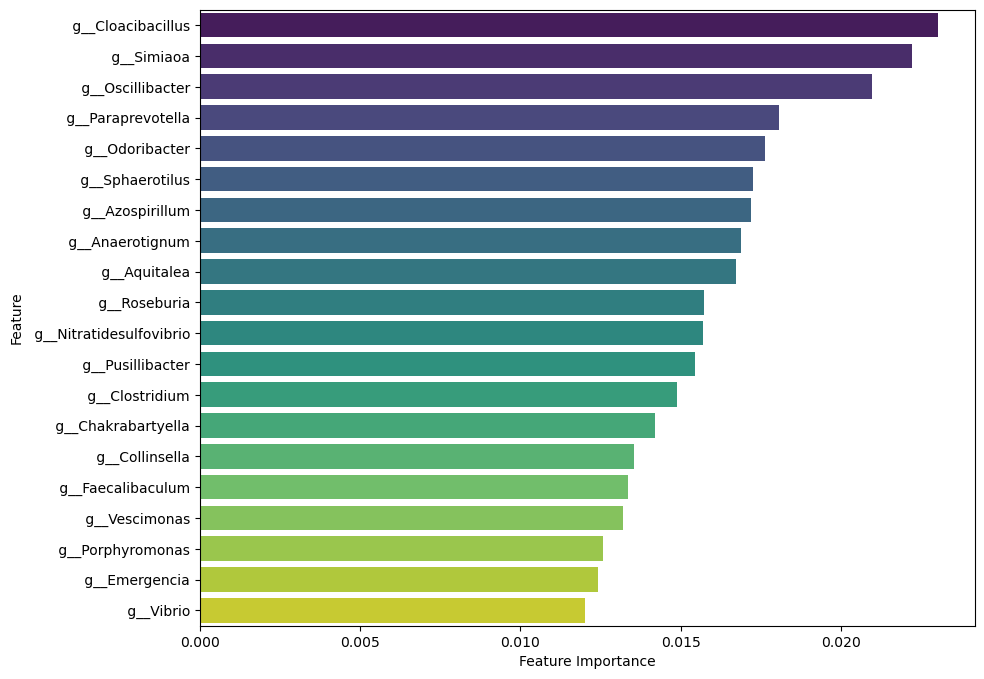

In [106]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_20_indices = feature_importances.argsort()[::-1][:20]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_20_indices], y=feature_names[top_20_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [110]:
print(feature_names[top_20_indices])

Index([' g__Cloacibacillus', ' g__Simiaoa', ' g__Oscillibacter',
       ' g__Paraprevotella', ' g__Odoribacter', ' g__Sphaerotilus',
       ' g__Azospirillum', ' g__Anaerotignum', ' g__Aquitalea',
       ' g__Roseburia', ' g__Nitratidesulfovibrio', ' g__Pusillibacter',
       ' g__Clostridium', ' g__Chakrabartyella', ' g__Collinsella',
       ' g__Faecalibaculum', ' g__Vescimonas', ' g__Porphyromonas',
       ' g__Emergencia', ' g__Vibrio'],
      dtype='object')


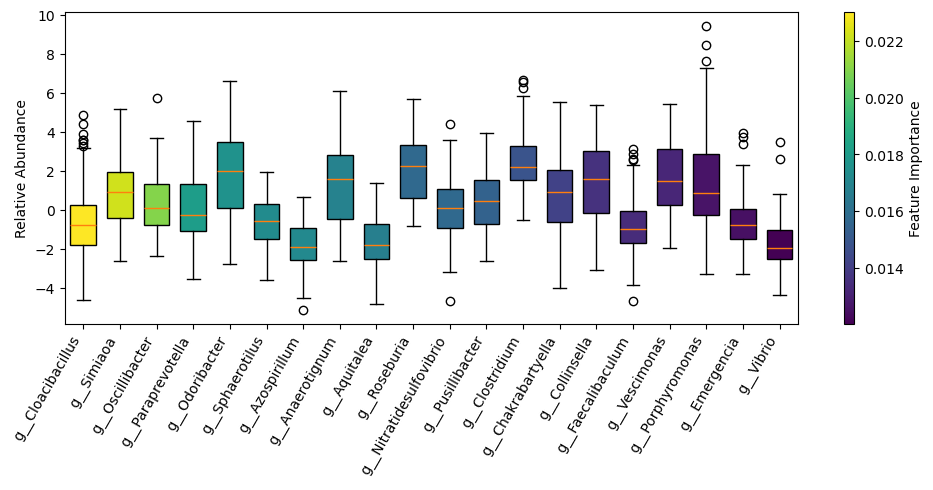

In [107]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

top_20_feature_names = feature_names[top_20_indices]

# Normalize feature importances
norm = Normalize(vmin=min(feature_importances[top_20_indices]), vmax=max(feature_importances[top_20_indices]))
cmap = plt.get_cmap('viridis')  # Choose a colormap
colors = [cmap(norm(importance)) for importance in feature_importances[top_20_indices]]

# Prepare data for boxplot
data = {}

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each box with the corresponding color based on feature importance
for i, (key, value) in enumerate(data.items()):
    box = ax.boxplot(value, positions=[i + 1], widths=0.7, patch_artist=True,
                     boxprops=dict(facecolor=colors[i], color='black'),
                     whiskerprops=dict(color='black'))

# Customize plot
ax.set_ylabel('Relative Abundance', fontsize=10)
ax.set_xticks(range(1, len(data) + 1))
ax.set_xticklabels(data.keys(), rotation=60, ha='right', fontsize=10)
plt.tight_layout()

# Add colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar, not for plotting
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label('Feature Importance', fontsize=10)

plt.show()

In [8]:
#Evaluate the robustness of ML framework

from sklearn.metrics import precision_score, recall_score, f1_score

# Define parameters for XGB model
params = {
    'max_depth': [3, 4, 5],
    'eta': [0.01, 0.1],
    'alpha': [1], # Include L1 regularization
    'colsample_bytree': [0.8],
    'subsample': [0.8, 0.9],
    'n_estimators':[100],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42)

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Robustness test
n_iterations = 20
robustness_train_scores = []
robustness_test_scores = []
robustness_auroc = []
precision_scores = []
recall_scores = []
f1_scores = []
important_features = []

for i in range(n_iterations):
    # Split the resampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=i, stratify=y)

    # Perform Grid Search with cross-validation
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=cv)
    grid_search.fit(X_train, y_train)

    # Evaluate the model on the training data of the resampled set
    train_score = grid_search.best_score_
    robustness_train_scores.append(train_score)

    # Evaluate the model on the test data of the resampled set
    y_pred = grid_search.best_estimator_.predict(X_test)
    test_score = accuracy_score(y_test, y_pred)
    robustness_test_scores.append(test_score)
    
    # Calculate AUROC score
    y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, y_test_proba)
    robustness_auroc.append(test_auroc)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Extract the best model's parameters and feature importances
    best_params = grid_search.best_params_
    best_xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric='logloss', **best_params)
    best_xgb_model.fit(X_train, y_train)

    feature_importances = best_xgb_model.feature_importances_
    top_20_indices = feature_importances.argsort()[::-1][:20]
    feature_names = X.columns
    top_20_features = feature_names[top_20_indices]
    important_features.extend(top_20_features)

# Calculate statistics for training data
robustness_train_mean = np.mean(robustness_train_scores)
robustness_train_std = np.std(robustness_train_scores)

# Calculate statistics for test data
robustness_test_mean = np.mean(robustness_test_scores)
robustness_test_std = np.std(robustness_test_scores)

# Calculate statistics for AUROC
robustness_auroc_mean = np.mean(robustness_auroc)
robustness_auroc_std = np.std(robustness_auroc)

# Calculate mean and standard deviation for precision, recall, and F1 score
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print("Train Mean Accuracy:", robustness_train_mean)
print("Train Std Accuracy:", robustness_train_std)
print("Test Mean Accuracy:", robustness_test_mean)
print("Test Std Accuracy:", robustness_test_std)
print("Mean AUROC:", robustness_auroc_mean)
print("Std AUROC:", robustness_auroc_std)
print("Mean Precision:", mean_precision)
print("Std Precision:", std_precision)
print("Mean Recall:", mean_recall)
print("Std Recall:", std_recall)
print("Mean F1 Score:", mean_f1)
print("Std F1 Score:", std_f1)


Train Mean Accuracy: 0.6973593073593074
Train Std Accuracy: 0.038801477014949216
Test Mean Accuracy: 0.6944444444444444
Test Std Accuracy: 0.06612433730132268
Mean AUROC: 0.7469780219780221
Std AUROC: 0.0666960321550603
Mean Precision: 0.7166905357714181
Std Precision: 0.07705786946365942
Mean Recall: 0.6527472527472529
Std Recall: 0.12000935840817918
Mean F1 Score: 0.6776276787209466
Std F1 Score: 0.08263743782935366


In [9]:
print(f"Train_accuracy_scores: {robustness_train_scores}" )
print(f"Test_accuracy_scores: {robustness_test_scores}" )
print(f"AUROC_scores: {robustness_auroc}" )
print(f"precision_scores: {precision_scores}" )
print(f"recall_scores: {recall_scores}" )
print(f"f1_scores: {f1_scores}" )

Train_accuracy_scores: [0.7, 0.6541125541125541, 0.6835497835497836, 0.719047619047619, 0.7004329004329005, 0.7, 0.7497835497835499, 0.6636363636363636, 0.6164502164502164, 0.6337662337662338, 0.7471861471861472, 0.7471861471861472, 0.7294372294372293, 0.7307359307359308, 0.635064935064935, 0.7398268398268397, 0.6917748917748918, 0.712121212121212, 0.7008658008658009, 0.6922077922077923]
Test_accuracy_scores: [0.7777777777777778, 0.6666666666666666, 0.6296296296296297, 0.6666666666666666, 0.7777777777777778, 0.7407407407407407, 0.5555555555555556, 0.7407407407407407, 0.7037037037037037, 0.7037037037037037, 0.5555555555555556, 0.7407407407407407, 0.7407407407407407, 0.7407407407407407, 0.7777777777777778, 0.7037037037037037, 0.6296296296296297, 0.6666666666666666, 0.6296296296296297, 0.7407407407407407]
AUROC_scores: [0.7912087912087912, 0.7802197802197802, 0.7087912087912088, 0.7307692307692308, 0.7967032967032966, 0.8351648351648352, 0.6208791208791209, 0.7967032967032966, 0.763736263

In [10]:
# Print or process the list of important features
print("Total number of selected features:", len(important_features))
important_features = pd.DataFrame(important_features)
important_features.to_csv('FI_XGB_SGBA_Stage.csv', index=False)

Total number of selected features: 400
